In [27]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.xkcd()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
PATH = "../input/"
print(os.listdir(PATH))

# Any results you write to the current directory are saved as output.

In [28]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [29]:
application_train = import_data('Data/application_train.csv')
application_test = import_data('Data/application_test.csv')

Memory usage of dataframe is 28.93 MB
Memory usage after optimization is: 6.62 MB
Decreased by 77.1%
Memory usage of dataframe is 28.43 MB
Memory usage after optimization is: 6.97 MB
Decreased by 75.5%


In [30]:
application_train = application_train[application_train['AMT_INCOME_TOTAL'] != 1.170000e+08]
application_train = application_train[application_train['AMT_REQ_CREDIT_BUREAU_QRT'] != 261]
application_train = application_train[application_train['OBS_30_CNT_SOCIAL_CIRCLE'] < 300]

In [31]:
application_train['DAYS_EMPLOYED'] = (application_train['DAYS_EMPLOYED'].apply(lambda x: x if x != 365243 else np.nan))

## Additional numerical features





In [32]:
def feat_ext_source(df):
    x1 = df['EXT_SOURCE_1'].fillna(-1) + 1e-1
    x2 = df['EXT_SOURCE_2'].fillna(-1) + 1e-1
    x3 = df['EXT_SOURCE_3'].fillna(-1) + 1e-1
    
    df['EXT_SOURCE_1over2_NAminus1_Add0.1'] = x1/x2
    df['EXT_SOURCE_2over1_NAminus1_Add0.1'] = x2/x1
    df['EXT_SOURCE_1over3_NAminus1_Add0.1'] = x1/x3
    df['EXT_SOURCE_3over1_NAminus1_Add0.1'] = x3/x1
    df['EXT_SOURCE_2over3_NAminus1_Add0.1'] = x2/x3
    df['EXT_SOURCE_3over2_NAminus1_Add0.1'] = x3/x2
    
    df['EXT_SOURCE_na1_2'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    df['EXT_SOURCE_na1_3'] = (application_train['EXT_SOURCE_1'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na2_1'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na2_3'] = (application_train['EXT_SOURCE_2'].isnull()) * (application_train['EXT_SOURCE_3'].fillna(0))
    df['EXT_SOURCE_na3_1'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_1'].fillna(0))
    df['EXT_SOURCE_na3_2'] = (application_train['EXT_SOURCE_3'].isnull()) * (application_train['EXT_SOURCE_2'].fillna(0))
    
    df['CREDIT_LENGTH'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    
    return df

In [33]:
application_train = feat_ext_source(application_train)
application_test  = feat_ext_source(application_test)

## Categorical encoding
The function was taken from [this kernel](https://www.kaggle.com/sz8416/simple-intro-eda-baseline-model-with-gridsearch). It allows to do OneHotEncoding (OHE) keeping only those columns that are common to train and test samples. OHE is performed using `pd.get_dummies`, which allows to convert categorical features, while keeping numerical untouched

In [34]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_dummy(train, test):
    train_d = pd.get_dummies(train, drop_first=False)
    test_d = pd.get_dummies(test, drop_first=False)
    # make sure that the number of features in train and test should be same
    for i in train_d.columns:
        if i not in test_d.columns:
            if i!='TARGET':
                train_d = train_d.drop(i, axis=1)
    for j in test_d.columns:
        if j not in train_d.columns:
            if j!='TARGET':
                test_d = test_d.drop(i, axis=1)
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(train.memory_usage().sum() / 1024**2, 
                                                                            train_d.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(test.memory_usage().sum() / 1024**2, 
                                                                            test_d.memory_usage().sum() / 1024**2))
    return train_d, test_d

application_train_ohe, application_test_ohe = cat_to_dummy(application_train, application_test)

Memory usage of train increases from 9.02 to 12.59 MB
Memory usage of test increases from 7.79 to 11.34 MB


In [35]:
# use this if you want to convert categorical features to dummies(default)
def cat_to_int(train, test):
    mem_orig_train = train.memory_usage().sum() / 1024**2
    mem_orig_test  = test .memory_usage().sum() / 1024**2
    categorical_feats = [ f for f in train.columns if train[f].dtype == 'object' or train[f].dtype.name == 'category' ]
    print('---------------------')
    print(categorical_feats)
    for f_ in categorical_feats:
        train[f_], indexer = pd.factorize(train[f_])
        test[f_] = indexer.get_indexer(test[f_])
    print('Memory usage of train increases from {:.2f} to {:.2f} MB'.format(mem_orig_train, 
                                                                            train.memory_usage().sum() / 1024**2))
    print('Memory usage of test increases from {:.2f} to {:.2f} MB'.format(mem_orig_test, 
                                                                            test.memory_usage().sum() / 1024**2))
    return categorical_feats, train, test

#categorical_feats, application_train_ohe, application_test_ohe = cat_to_int(application_train, application_test)

Use this instead if you want to make use of the internal categorical feature treatment in lightgbm.

In [ ]:
#application_train_ohe, application_test_ohe = (application_train, application_test)

## Deal with category imbalance
Use a standard library (`imblearn`) to to random undersampling on the dominating category. Use if if you want to repeat the HP optimisation

In [36]:

#from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(random_state=314)
#X_rus, y_rus = rus.fit_sample(application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(-1), 
#                              application_train_ohe['TARGET'])

# You can use the full sample and do sample weighting in lightgbm using `is_unbalance` OR `scale_pos_weight` argument
# But it makes the code to run 8x..10x slower, which is ok for the run with pre-optimised parametersm but is too slow for HP optimisation
X_rus, y_rus = (application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                application_train_ohe['TARGET'])

# Model fitting with HyperParameter optimisation
We will use LightGBM classifier - LightGBM allows to build very sophysticated models with a very short training time.
### Split the full sample into train/test (80/20)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.20, random_state=314, stratify=y_rus)

### Prepare learning rate shrinkage

In [38]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

### Use test subset for early stopping criterion 
This allows us to avoid overtraining and we do not need to optimise the number of trees

In [39]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

### Set up HyperParameter search
We use random search, which is more flexible and more efficient than a grid search

In [40]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [41]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

Run this cell, to do HP optimisation. To save time `opt_parameters` was directly hardcoded below.

In [ ]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [42]:
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

## Tune the weights of unbalanced classes
Following discussion in [this comment](https://www.kaggle.com/mlisovyi/modular-good-fun-with-ligthgbm/comments#337494), there was a small tuning of the disbalanced sample weight:


In [43]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9234,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='None', min_child_samples=399, min_child_weight=0.1,
               min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=13,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=5,
               silent=True, subsample=0.855, subsample_for_bin=200000,
               subsample_freq=0)

In [44]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [45]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[51]	valid's auc: 0.742174
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.740147
Early stopping, best iteration is:
[77]	valid's auc: 0.740709
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.73752
Early stopping, best iteration is:
[99]	valid's auc: 0.737657
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.736745
Early stopping, best iteration is:
[73]	valid's auc: 0.738987
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[57]	valid's auc: 0.739261
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[65]	valid's auc: 0.743462
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[64]	valid's auc: 0.741121
Training until validation scores don't improve for 30 ro

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   17.6s finished


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid's auc: 0.742595
Best score reached: 0.7425794618668223 with params: {'scale_pos_weight': 2} 


As an outcome, precision of the classifier does not depend much on the internal class weighting, but `weight=1` still turns out to give slightly better performance that weighted scenarios.

### Look at the performance of the top-5 parameter choices
(the list is inverted)

In [ ]:
#print("Valid+-Std     Train  :   Parameters")
#for i in np.argsort(gs.cv_results_['mean_test_score'])[-5:]:
#    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs.cv_results_['params'][i], 
#                                    gs.cv_results_['mean_test_score'][i], 
#                                    gs.cv_results_['mean_train_score'][i],
#                                    gs.cv_results_['std_test_score'][i]))

In [ ]:
print("Valid+-Std     Train  :   Parameters")
for i in np.argsort(gs_sample_weight.cv_results_['mean_test_score'])[-5:]:
    print('{1:.3f}+-{3:.3f}     {2:.3f}   :  {0}'.format(gs_sample_weight.cv_results_['params'][i], 
                                    gs_sample_weight.cv_results_['mean_test_score'][i], 
                                    gs_sample_weight.cv_results_['mean_train_score'][i],
                                    gs_sample_weight.cv_results_['std_test_score'][i]))

## Build the final model
We do training with the 0.8 subset of the dataset and 0.2 subset for early stopping. We use the tuned parameter values but a smaller learning rate to allow smoother convergence to the minimum

In [47]:
#Configure from the HP optimisation
#clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.744747
Early stopping, best iteration is:
[131]	valid's auc: 0.746013


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9234,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='None', min_child_samples=399, min_child_weight=0.1,
               min_split_gain=0.0, n_estimators=5000, n_jobs=4, num_leaves=13,
               objective=None, random_state=314, reg_alpha=2, reg_lambda=5,
               silent=True, subsample=0.855, subsample_for_bin=200000,
               subsample_freq=0)

### Plot feature importance

/apps/anaconda2/envs/jupyter-py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


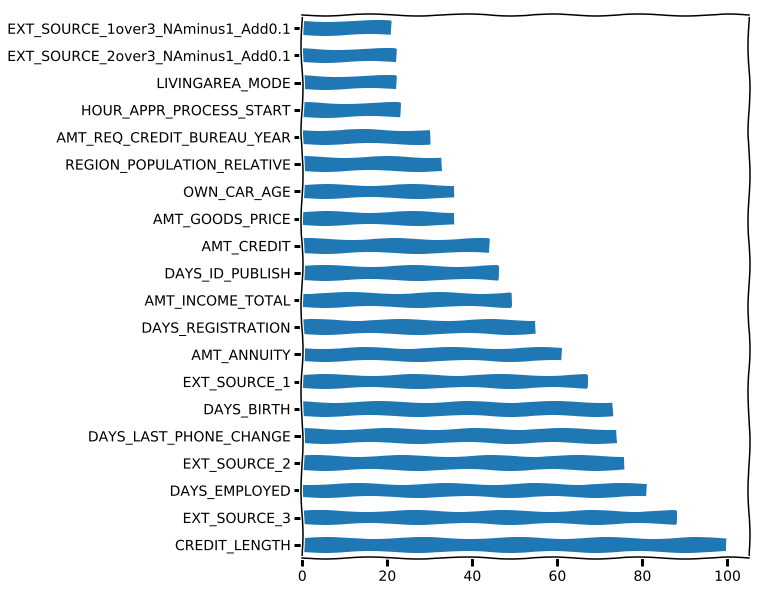

In [48]:
feat_imp = pd.Series(clf_final.feature_importances_, index=application_train_ohe.drop(['SK_ID_CURR', 'TARGET'], axis=1).columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

# Predict on the submission test sample

In [52]:
probabilities = clf_final.predict_proba(application_test_ohe.drop(['SK_ID_CURR'], axis=1))
submission = pd.DataFrame({
    'SK_ID_CURR': application_test_ohe['SK_ID_CURR'],
    'TARGET':     [ row[1] for row in probabilities]
})
submission.to_csv("submission_01.csv", index=False)